In [2]:
from web3 import Web3
import requests
import time

In [3]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
w3 = Web3(Web3.HTTPProvider("https://api.avax.network/ext/bc/C/rpc"))

lb_proxy = Web3.toChecksumAddress("0xee5A90098b270596Ec35D637b30d908C862c86df")
abi=requests.get(f"https://api.snowtrace.io/api?module=contract&action=getabi&address={lb_proxy}").json()['result']

In [5]:
lb_impl = Web3.toChecksumAddress("0xD446eb1660F766d533BeCeEf890Df7A69d26f7d1")
contract = w3.eth.contract(address=lb_impl, abi=abi)

In [6]:
def get_decimals(address):
    abi=requests.get(f"https://api.snowtrace.io/api?module=contract&action=getabi&address={Web3.toChecksumAddress(address)}").json()['result']

    contract = w3.eth.contract(address=address, abi=abi)
    return contract.functions.decimals().call()

In [7]:
tokenX = contract.functions.getTokenX().call()
tokenY = contract.functions.getTokenY().call()

In [10]:
active_bin = contract.functions.getActiveId().call()
left_bins = [contract.functions.getNextNonEmptyBin(True, active_bin).call()]
right_bins = [contract.functions.getNextNonEmptyBin(False, active_bin).call()]


In [11]:
while True:
    next_bin = contract.functions.getNextNonEmptyBin(True, left_bins[0]).call()
    if next_bin > left_bins[0] or len(left_bins)==250:
        break
    else:
        left_bins.insert(0, next_bin)

print("Found all USDC bins, looking for AVAX bins...")

while True:
    next_bin = contract.functions.getNextNonEmptyBin(False, right_bins[-1]).call()
    if next_bin < right_bins[-1] or len(right_bins)==250:
        break
    else:
        right_bins.append(next_bin)

Found all USDC bins, looking for AVAX bins...


In [12]:
target_bins = left_bins + [active_bin] + right_bins

In [17]:
import multiprocessing
import os

def process_bin(bin):
    bin_step = 0.002
    reserveX, reserveY = contract.functions.getBin(bin).call()
    bin_price = (1+bin_step)**(bin-2**23)
    print(bin, end="\r")
    return {"bin_id" : bin, "reserveX" : reserveX, "reserveY" : reserveY, "bin_price" : bin_price}


def get_liquidity_shape_parallel(target_bins: list) -> list:
    data = []

    with multiprocessing.Pool(processes=os.cpu_count()) as pool:
        results = pool.map(process_bin, target_bins)

    return results


In [13]:
data = []
bin_step = 0.002


for i, bin in enumerate(target_bins):
    print(f"Retrieving bin {i} out of {len(target_bins)}. {len(target_bins)-i} bins left", end="\r")
    reserveX, reserveY = contract.functions.getBin(bin).call()
    bin_price = (1+bin_step)**(bin-2**23)
    data.append({"bin_id" : bin, "reserveX" : reserveX, "reserveY" : reserveY, "bin_price" : bin_price})

In [45]:
df = pd.DataFrame.from_dict(data)
df.set_index('bin_id')

,reserveX,reserveY,bin_price
bin_id,,,
8375654,0,6027060,5.748245e-12
8375655,0,6027060,5.759742e-12
8375656,0,6027060,5.771261e-12
8375657,0,6027060,5.782804e-12
8375658,0,6027060,5.794369e-12
...,...,...,...
8376150,116389515805931832064,0,1.548550e-11
8376151,113942474166928265345,0,1.551647e-11
8376152,91642076721804578254,0,1.554750e-11


In [32]:
df[(df['reserveX'] == 0) & (df['reserveY'] == 0)]

,bin_id,reserveX,reserveY,bin_price


In [33]:
df[(df['reserveX'] > 0) & (df['reserveY'] > 0)]

,bin_id,reserveX,reserveY,bin_price
250,8375904,8203661420819549681802,5097189,9.472523e-12


In [46]:
tokenX_decimals = 18
tokenY_decimals = 6

tokenX_symbol = "AVAX"
tokenY_symbol = "USDC"

df['reserveX'] = df['reserveX'].div(10**tokenX_decimals)
df['reserveY'] = df['reserveY'].div(10**tokenY_decimals) 
df['bin_price'] = df['bin_price'] * 10**(tokenX_decimals-tokenY_decimals)
df["reserveX_in_Y"] = df['reserveX'] * df['bin_price']
df = df[(df.bin_price > 7.5) & (df.bin_price < 12.5)]

df = df.sort_values(by='bin_price')
df

,bin_id,reserveX,reserveY,bin_price,reserveX_in_Y
134,8375788,0.0,57137.902727,7.512941,0.0
135,8375789,0.0,634.964680,7.527967,0.0
136,8375790,0.0,632.271469,7.543023,0.0
137,8375791,0.0,629.333422,7.558109,0.0
138,8375792,0.0,626.395374,7.573225,0.0
...,...,...,...,...,...
384,8376038,219.04281,0.000000,12.380562,2711.873045
385,8376039,346.92089,0.000000,12.405323,4303.665667
386,8376040,357.673083,0.000000,12.430134,4445.9242
387,8376041,338.07283,0.000000,12.454994,4210.695019


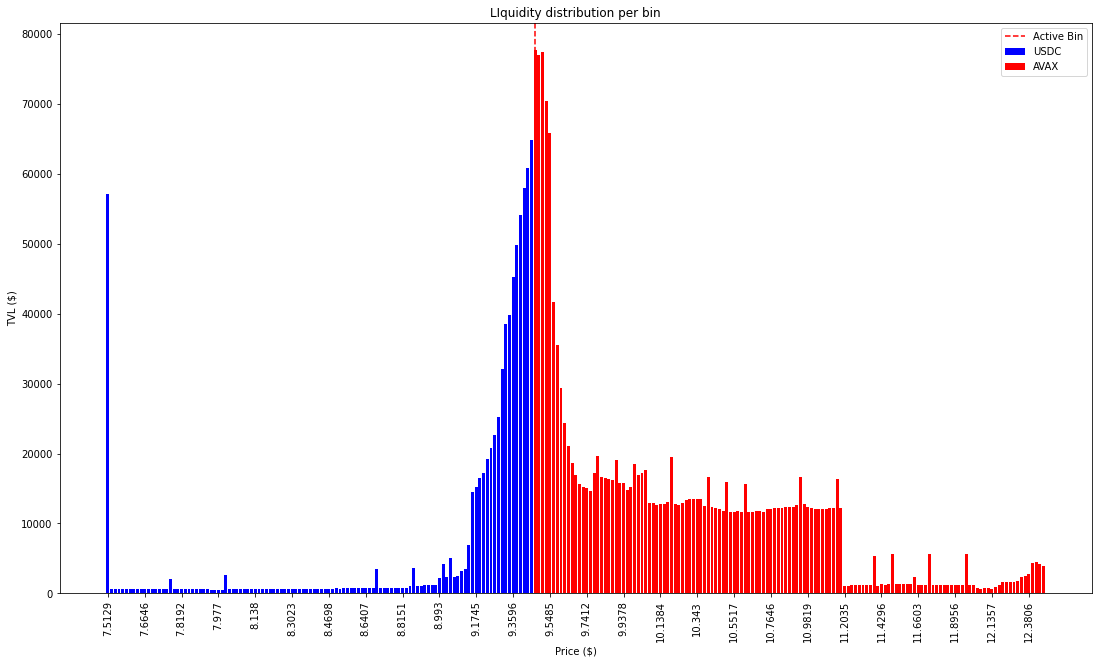

In [47]:

tick_gap = 10

xticks = df.bin_id[::tick_gap]
xtick_lables = df.bin_price[::tick_gap]

fig, ax = plt.subplots()

ax.bar(list(df.bin_id), list(df.reserveY), label=tokenY_symbol, color='b', edgecolor="none")
ax.bar(list(df.bin_id), list(df.reserveX_in_Y), bottom=np.array(df.reserveY, dtype=float), label=tokenX_symbol, color='r', edgecolor="none")

ax.set_ylabel('TVL ($)')
ax.set_xlabel('Price ($)')
ax.set_title('LIquidity distribution per bin')
ax.legend()

ax.ticklabel_format(style='plain', useOffset=False)
fig.set_size_inches(18.5, 10.5, forward=True)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xtick_lables, 4), rotation=90)
# plt.xticks(xticks, rotation=90)
ax.axvline(x=active_bin, color='red', linestyle='--', label='Active Bin')
ax.legend()
plt.show()

In [46]:
xticks[250]

8375899

In [83]:
df[(df['bin_price'] > 2.68)]["reserveX"].sum()

1300.1263747663477

In [34]:
xtick_lables

0       5.679747
50      6.276464
100     6.935873
150     7.664559
200     8.469802
250     9.378363
300    10.363660
350    11.452471
400    12.655674
450    13.985286
Name: bin_price, dtype: float64